# Change point based Clustering

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [5]:
import sys
sys.path.append('../')

In [6]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    validation_filtering=(True, 4*5)
)

In [155]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "user")][1]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
sli_data = dataset.loc[:, list(record.pk.get_root_metrics())]
dataset.shape

user/pod-cpu-hog/3


(180, 182)

In [156]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [157]:
from tsdr.multireducer import change_point_clustering
from tsdr.smooth import moving_average

In [158]:
cinfo, remove_metrics = change_point_clustering(cause_dataset, n_bkps=1, proba_threshold=0.5)
cinfo, remove_metrics

({'c-user_memory_rss': [],
  'c-user_cpu_usage_seconds_total': [],
  'c-user_cpu_cfs_throttled_periods_total': [],
  'c-user_memory_cache': [],
  'c-user_memory_working_set_bytes': [],
  'c-user_memory_usage_bytes': [],
  'c-user_cpu_cfs_throttled_seconds_total': [],
  'c-user_memory_mapped_file': [],
  'c-user_cpu_user_seconds_total': []},
 ['c-user_network_transmit_packets_total',
  'c-user_cpu_system_seconds_total',
  'c-user_network_receive_bytes_total',
  'c-user_cpu_cfs_periods_total',
  'c-user_network_receive_packets_total',
  'c-user_network_transmit_bytes_total',
  'c-user_threads'])

In [159]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [160]:
cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=4))
sli_data = sli_data.apply(lambda x: moving_average(x, window_size=4))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


162

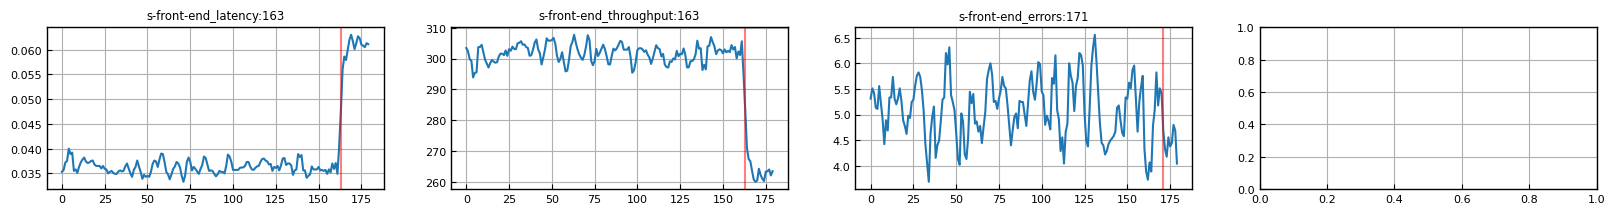

In [161]:
import math
binseg = rpt.Binseg(model="normal", jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    bkp = binseg.fit(scipy.stats.zscore(sli_data[sli].values)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_data[sli].values)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

In [162]:
data = cause_dataset
n_bkps = 1

metrics = data.columns.tolist()
binseg = rpt.Binseg(model="normal", jump=1)
change_points: list[int] = []
for metric in metrics:
    x = data[metric].to_numpy()
    change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    change_points.append(change_point)
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    metric="euclidean",
    allow_single_cluster=True,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=2.0,
).fit(np.array([change_points]).T)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, clusterer.labels_, change_points, clusterer.outlier_scores_, clusterer.probabilities_), columns=["metric", "cluster_id", "change_point", "outlier_score", "probability"]))
print("persistence", clusterer.cluster_persistence_)

# def agglomerative_coefficient(x: np.ndarray, centroid: int) -> float:
#     sse = int(np.sum((x - centroid) ** 2))
#     return 1 / (1 + sse) * x.size  # cluster density * cluster size
def agglomerative_coefficient(x: np.ndarray, centroid: int) -> float:
    return x.size

cluster_id_to_centroid = {
    cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
    for cluster_id in np.unique(clusterer.labels_)
    if cluster_id != -1  # skip noise cluster
}
cluster_id_to_change_points: dict[int, list[int]] = defaultdict(list)
clusters_with_centroid: dict[tuple[int, int], list[str]] = defaultdict(list)
# print(list(zip(clusterer.labels_, metrics, change_points)))
for cluster_id, metric, change_point, prob in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
    if cluster_id == -1 or prob <= 0.5:  # skip noise features
        continue
    centroid = cluster_id_to_centroid[cluster_id]
    clusters_with_centroid[(cluster_id, centroid)].append(metric)
    cluster_id_to_change_points[cluster_id].append(change_point)

# # choose a cluster having max metrics and the adjacent clusters
# import pprint
# for x in clusters_with_centroid.items():
#     print(agglomerative_coefficient(np.array(cluster_id_to_change_points[x[0][0]], dtype=int), x[0][1]), x)

max_cluster = min(clusters_with_centroid.items(), key=lambda x: abs(slis_bkp - x[0][1]))  # the nearest cluster the slis changepoint
sorted_clusters = sorted(clusters_with_centroid.items(), key=lambda x: x[0][1])  # sort by change point centroid
max_cluster_idx: int = [
    i for i, ((cluster_id, cp), _) in enumerate(sorted_clusters) if max_cluster[0][0] == cluster_id
][0]
keep_clusters: list[int] = [max_cluster[0][0]]
# for (cluster_id, change_point), _ in reversed(sorted_clusters[0:max_cluster_idx]):  # backward
#     change_point_of_max_cluster = max_cluster[0][1]
#     if abs(change_point - change_point_of_max_cluster) > 1:
#         break
#     keep_clusters.append(cluster_id)

# for (cluster_id, change_point), _ in sorted_clusters[max_cluster_idx + 1 :]:  # forward
#     change_point_of_max_cluster = max_cluster[0][1]
#     if abs(change_point - change_point_of_max_cluster) > 1:
#         break
#     keep_clusters.append(cluster_id)

keep_metrics: list[str] = list(
    itertools.chain.from_iterable(
        [clusters_with_centroid[(cluster, cluster_id_to_centroid[cluster])] for cluster in keep_clusters]
    )
)
remove_metrics: list[str] = list(set(metrics) - set(keep_metrics))
clustering_info: dict[str, list[str]] = {metric: [] for metric in keep_metrics}
clustering_info, remove_metrics

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1379: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


,metric,cluster_id,change_point,outlier_score,probability
0,c-user_cpu_user_seconds_total,0,162,0.0,1.0
1,c-user_cpu_cfs_throttled_seconds_total,0,162,0.0,1.0
2,c-user_memory_working_set_bytes,0,162,0.0,1.0
3,c-user_memory_usage_bytes,0,162,0.0,1.0
4,c-user_memory_cache,0,162,0.0,1.0
5,c-user_memory_rss,0,162,0.0,1.0
6,c-user_network_receive_bytes_total,0,167,NaN,0.0
7,c-user_memory_mapped_file,0,162,0.0,1.0
8,c-user_cpu_system_seconds_total,0,164,NaN,0.0
9,c-user_network_transmit_bytes_total,1,3,0.0,1.0


persistence [1. 1.]


({'c-user_cpu_user_seconds_total': [],
  'c-user_cpu_cfs_throttled_seconds_total': [],
  'c-user_memory_working_set_bytes': [],
  'c-user_memory_usage_bytes': [],
  'c-user_memory_cache': [],
  'c-user_memory_rss': [],
  'c-user_memory_mapped_file': [],
  'c-user_cpu_usage_seconds_total': [],
  'c-user_cpu_cfs_throttled_periods_total': []},
 ['c-user_network_transmit_packets_total',
  'c-user_cpu_system_seconds_total',
  'c-user_network_receive_bytes_total',
  'c-user_cpu_cfs_periods_total',
  'c-user_network_receive_packets_total',
  'c-user_network_transmit_bytes_total',
  'c-user_threads'])

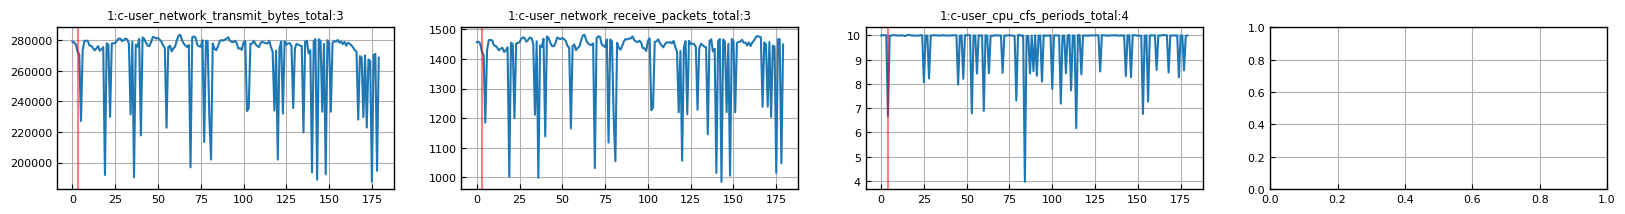

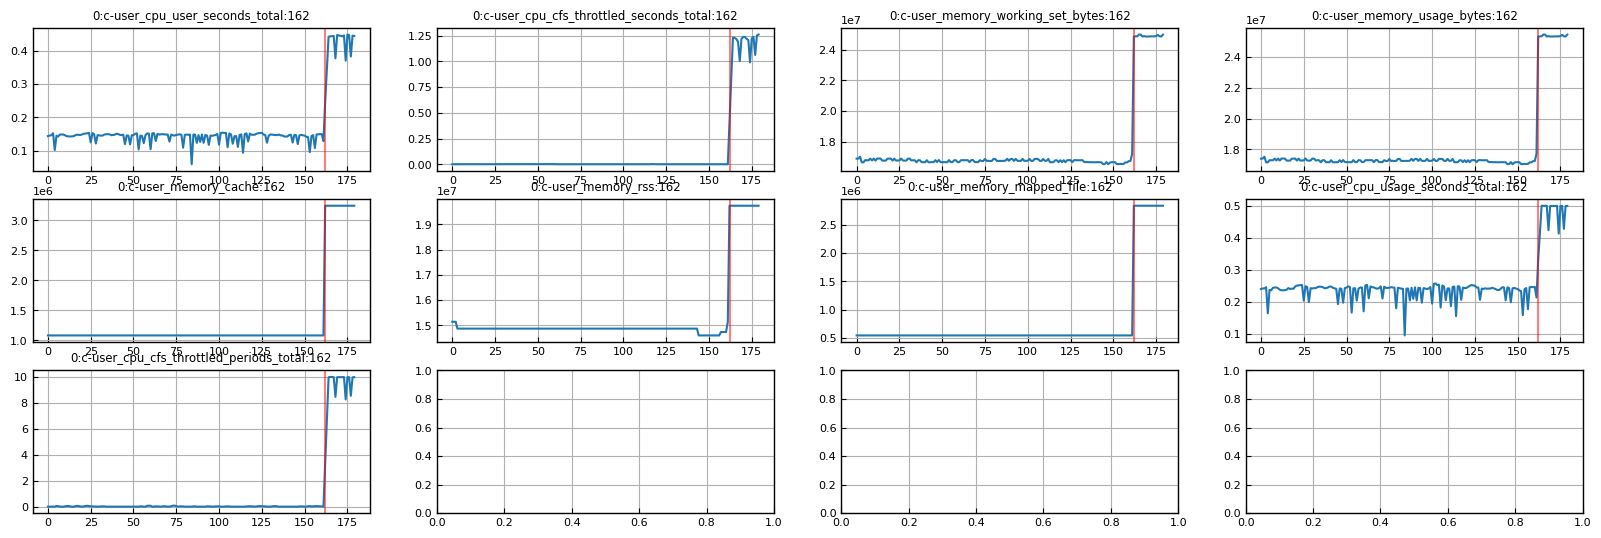

In [154]:
import math

plt.close()
for (cluster_id, centroid), metrics in sorted_clusters:
    fig, axs = plt.subplots(math.ceil(len(metrics)/4), ncols=4)
    fig.set_size_inches(20, 0.7*len(metrics))
    for ax, metric in zip(axs.flatten(), metrics):
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        bkp = metric_to_bkp[metric]
        ax.axvline(bkp, color='red', alpha=0.5)
        ax.set_title(f"{cluster_id}:{metric}:{bkp}")